# Amazon food review dataset apply Logistic regression

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews


# Objective
1. Try predicting review using SVM grid and random search gamma and c
2. Get lambda 1 2(L1 and L2) using grid search and random search CV 
3. For L1 regularization try increasing lambda and see error. Get non zero element in w
4. Get features importance check for multicolinearity by adding small value
5. Plot accuracy and hyperparameter

# Import data and libraries
 

In [12]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [13]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [14]:
#take only 50000 data
print('total data \n',sorted_data['Score'].value_counts())
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(10000)
#take stratified sampling i.e. positive and negative reviews are proportionate to raw data
_ , clean_data = train_test_split(sorted_data, test_size = 30000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

total data 
 positive    307063
negative     57110
Name: Score, dtype: int64


positive    25295
negative     4705
Name: Score, dtype: int64

In [15]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    
clean_data['CleanedText']=final_string
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)



(30000, 11)


167691    b'realli happi tea ran tea purchas europ felt ...
239691    b'love bake mix famili love thank pamela muell...
Name: CleanedText, dtype: object

# Split train and test

In [16]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (21000,) (9000,) (21000,) (9000,)
positive and negative review in train and test
 positive    17832
negative     3168
Name: Score, dtype: int64 
 positive    7463
negative    1537
Name: Score, dtype: int64


# Create BOW and try grid search for logistic regreession with penalty l1 and l2

In [17]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train_raw)

#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())

(21000, 18278) (9000, 18278)


In [18]:
from sklearn.preprocessing import StandardScaler

#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.preprocessing import label_binarize

encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_train=encoded_labels

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_test=encoded_labels


print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (21000, 18278) (9000, 18278) (21000,) (9000,)


In [19]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve

# Use grid search for L2
C=[10**-3, 10**-2, 10**-1, 1,10]

#param_range=C;

#c1=np.arrange(1, 250, 20)
penalty=['l1', 'l2']

tuned_parameters=dict(penalty=penalty,C=C)

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
print(type(X_train),type(y_train))


Best parameters 
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
<class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


In [20]:
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
#confusion matrix
pred2 = model.predict(X_test)
mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
aa=pd.DataFrame({'type':['Grid search BOW'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
#print(aa)

# Print coefficients
# check no of parameter
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
#print(model.coef_[0],model.coef_[8])
#print(model.coef_)
#print(model.C,model.penalty)

confusion matrix
 Predicted    0     1   All
Actual                    
0          747   790  1537
1          179  7284  7463
All        926  8074  9000
Count of non zero element in coefficient 18278
Model train and test score C and penalty 0.974571428571 0.892333333333 0.001 l2


try random search

# Apply Random search

In [21]:
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
#Using random search
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
#print('Model best extimator \n',model.best_estimator_)
#print(model.score(X_test, y_test))
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
# create model with the best parameter from random search
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search BOW'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
#confusion matrix
pred2 = model.predict(X_test)
mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
print(aa)

Count of non zero element in coefficient 18278
Model train and test score C and penalty 0.990857142857 0.885777777778 0.01 l2
confusion matrix
 Predicted     0     1   All
Actual                     
0           875   662  1537
1           366  7097  7463
All        1241  7759  9000
       C penalty  test_score  train_score               type
0  0.001      l2    0.892333     0.974571    Grid search BOW
0  0.010      l2    0.885778     0.990857  Random search BOW


# Try increasing lambda for L1 and see error and sparcity(non 0 element of w)

In [22]:
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_

  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
  #print('model score',model.score(X_test,y_test))

#print(w)


Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.001 4 (1, 18278) 0.849142857143 0.829222222222
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.01 888 (1, 18278) 0.909 0.886555555556
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.1 4178 (1, 18278) 0.984714285714 0.895777777778
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 1 5115 (1, 18278) 0.998714285714 0.873222222222
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 10 5145 (1, 18278) 1.0 0.859111111111
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 100 5674 (1, 18278) 1.0 0.852666666667
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 1000 8359 (1, 18278) 

So We can see as C decreases i.e. lambda increases more coefficients are getting 0 and  test accuracy increases when C too low accuracy decreases again if C is too low
# See top features using the weights

In [23]:
#print(model.coef_[1])
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
#print(indices)
#print(count_vect.get_feature_names())

In [24]:
#create optimum model
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)


def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    #negative words are sorted with -ve
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    top_pos_fet=[]
    top_neg_fet=[]
    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)
        top_pos_fet.append(feat)

    print("\n")

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)
        top_neg_fet.append(feat)
        
    return top_pos_fet,top_neg_fet 

print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(count_vect, model)

Top 10 words for both review 0 negative 1 positive with weights

0 -0.298581527223 disappoint
0 -0.272111698062 worst
0 -0.224411686657 return
0 -0.203266486941 threw
0 -0.201739922058 aw
0 -0.192431243904 terribl
0 -0.18740445635 unfortun
0 -0.183026389691 wast
0 -0.175135513463 bland
0 -0.167223006745 didnt


1 0.555265011304 love
1 0.552539174726 great
1 0.476073414311 best
1 0.380479651656 delici
1 0.343530048721 good
1 0.306126878833 excel
1 0.294409265085 perfect
1 0.282933263072 favorit
1 0.249492790648 nice
1 0.213313608528 find


# Check multicolinearity with perbutation test by adding small noise to sparse matrix
The noise is with mean 0 and sd=.0001

In [25]:
# Check VIF score of the above selected variables
#vif = pd.DataFrame()
#print(x.toarray().shape,x.shape[1])
#vif["VIF Factor"] = [variance_inflation_factor(x.toarray(), i) for i in range(x.shape[1])]
#vif["features"] = count_vect.get_feature_names()
#print(vif)
#for i in top_pos_fet:
#  print(vif[(vif[["features"]]==i).values])

#for i in top_neg_fet:
#  print(vif[(vif[["features"]]==i).values])

# creating VIF is giving a lot of inf

In [26]:
#refer https://medium.com/@dhwajraj/learning-python-regression-analysis-part-9-tests-and-validity-for-regression-models-78dcd5cde3a1
# to find colinearity by eigen value
#corr=np.corrcoef(x,rowvar=0)
#W,V=np.linalg.eig(corr)
#If at least one of the eigen values of the correlation matrix is close to zero then we can say that multicollinearity exists in the dataset

#The eigen values at index 3,4 and 5 are close to zero. There corresponding eigen vectors are:

#in the output produced above, column index 2 and 3 have near zero values in all three eigen vectors so we can say that columns 0,1,4 and 5 are strongly correlated with each other so any one of them would be sufficient to capture the essence of the other three columns.




In [27]:
from scipy import *
import random
from scipy.sparse import *
    
#print(X_train)
#print(X_train.data.shape[0])
#X_train.todense()
#print("hi")
#X_train.data+=X_train
#X_train.todense()
X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#print(X_train)

# Create model after adding some noise and check weights
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)

print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(count_vect, model)

Top 10 words for both review 0 negative 1 positive with weights

0 -0.298578263487 disappoint
0 -0.272111605877 worst
0 -0.22441091346 return
0 -0.203269639429 threw
0 -0.201738894913 aw
0 -0.192427443842 terribl
0 -0.187401989428 unfortun
0 -0.18302463223 wast
0 -0.175133105309 bland
0 -0.167222053226 didnt


1 0.555272463126 love
1 0.552549898008 great
1 0.476072518536 best
1 0.380481253714 delici
1 0.343537267526 good
1 0.306128981766 excel
1 0.29440825798 perfect
1 0.282933667135 favorit
1 0.24949603434 nice
1 0.21331462335 find


So we can see after adding noise the weights of top 20 words are almost same as earlier, so multicolinearity doesnot exist

# Plot traing and CV error with C and l1 penalty

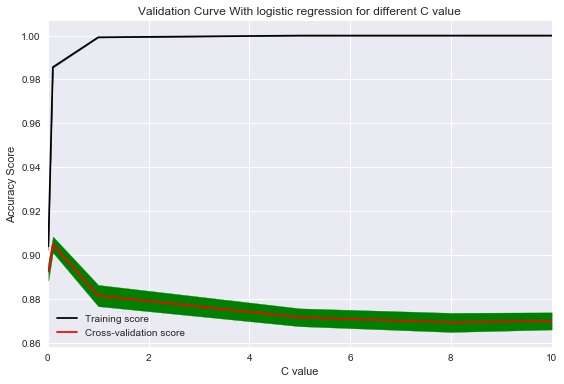

In [28]:
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]


train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Plot traing and CV error with C and l2 penalty

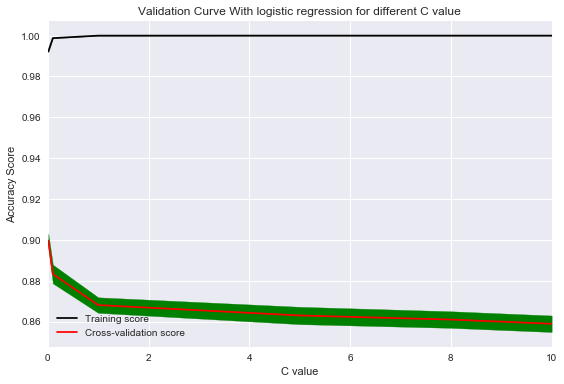

In [29]:
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]


train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# TFIDF

(21000, 18278) (9000, 18278)
Best parameters 
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
confusion matrix
 Predicted   0     1   All
Actual                   
0          14  1523  1537
1           0  7463  7463
All        14  8986  9000
Count of non zero element in coefficient 18278
Model train and test score C and penalty 0.974571428571 0.830777777778 0.001 l2
Model best extimator 
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 18278
Model train and test score C and penalty 0.990857142857 0.838333333333 0.01

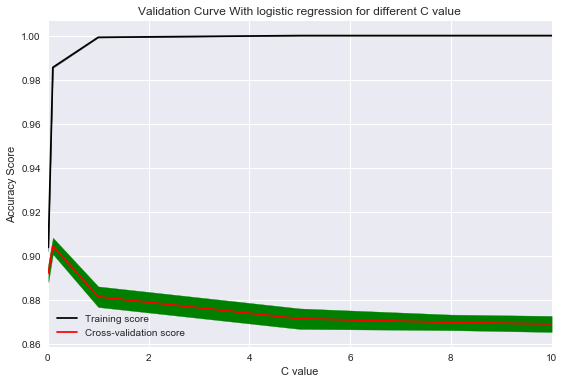

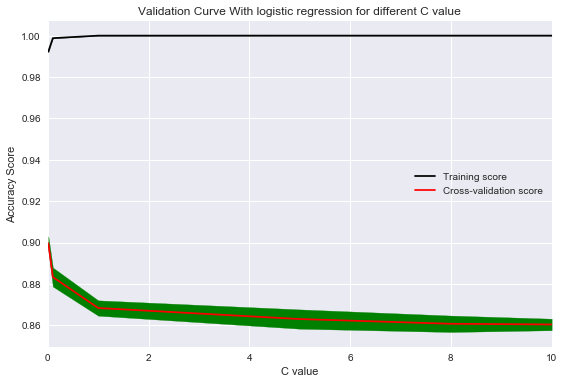

In [30]:
# Create BOW and try grid search for logistic regreession with penalty l1 and l2
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(X_train_raw)
#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())
#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
#below already done
#encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # negative will be 0 and positive will be 1
#encoded_labels = np.ravel(encoded_column_vector) # Reshape array
#y_train=encoded_labels
#encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # negative will be 0 and positive will be 1
#encoded_labels = np.ravel(encoded_column_vector) # Reshape array
#y_test=encoded_labels

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search TFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
#confusion matrix
pred2 = model.predict(X_test)
mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)

w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search TFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#confusion matrix
mat=pd.crosstab(y_test, model.score(X_test,y_test), rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat)

#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect, model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# AVG W2V

size of X_train, X_test, y_train , y_test  (21000, 50) (9000, 50) (21000,) (9000,)
Best parameters 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 47
Model train and test score C and penalty 0.881714285714 0.829111111111 10 l1
Model best extimator 
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 50
Model train and test score C and penalty 0.881714285714 0.829111111111 100 l2
         C penalty  test_score  train_score                  type
0    0.001      l2    0.892333     0.9

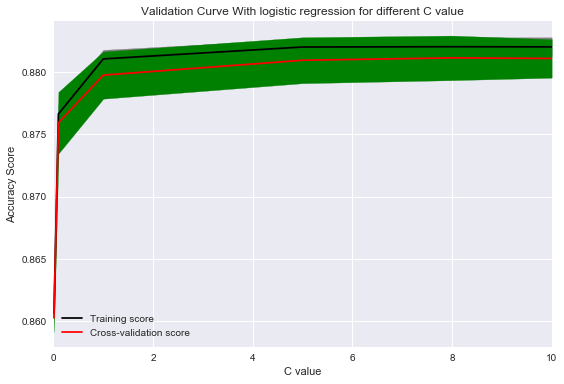

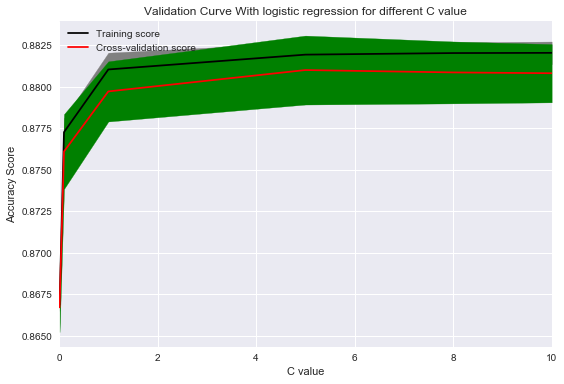

In [31]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
#convert W2V train data
i=0
#create a list of list to be used in W2V 
list_of_sent_train=[]
for sent in X_train_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)  

    
#convert W2V test data
i=0
#create a list of list to be used in W2V 
list_of_sent_test=[]
for sent in X_test_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

# try
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)

print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search AVGW2V'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search AVGW2V'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#confusion matrix
pred2 = model.predict(X_test)
mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)

#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(sent_vectors.toarray() , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
#X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
#model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(sent_vectors.toarray(), model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# TFIDF AVGW2V

size of X_train, X_test, y_train , y_test  (21000, 50) (9000, 50) (21000,) (9000,)
Best parameters 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
confusion matrix
 Predicted    0     1   All
Actual                    
0          387  1150  1537
1          196  7267  7463
All        583  8417  9000
Count of non zero element in coefficient 46
Model train and test score C and penalty 0.865523809524 0.850444444444 10 l1
Model best extimator 
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 50
Model train and test score 

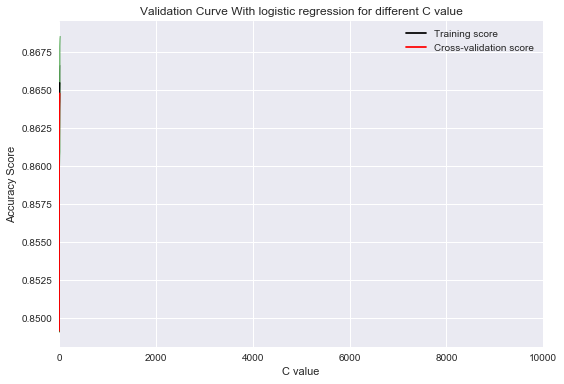

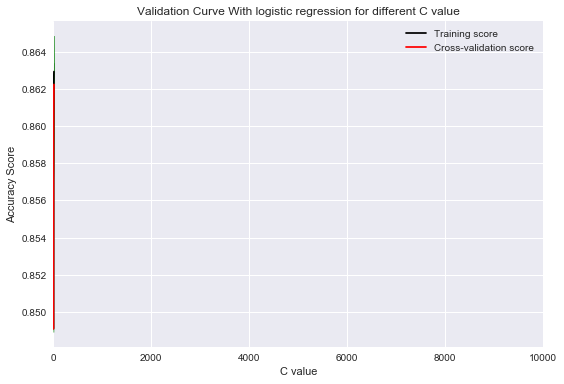

In [32]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(X_train_raw)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
#tfidf_sent_vectors.

# do for test
final_tf_idf=tf_idf_vect.transform(X_test_raw)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1



#x=tfidf_sent_vectors
#y = clean_data['Score']
#n=len(x)
#n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]
#y_test=y[0:n1]
#y_train=y[n1:n+1]
#print('X y train test ',len(X_train),len(X_test),y_train.shape,y_test.shape)
X_train = pd.DataFrame(tfidf_sent_vectors_train)
X_test = pd.DataFrame(tfidf_sent_vectors_test)
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search AVGW2VTFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
#confusion matrix
pred2 = model.predict(X_test)
mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)

w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search AVGW2VTFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
#X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
#model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect, model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


Ignore the above 2 plots those plots are plotted below again

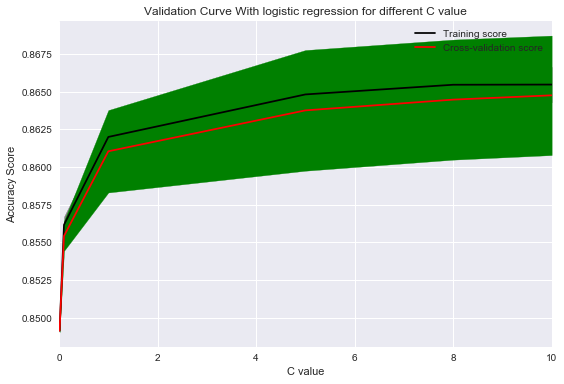

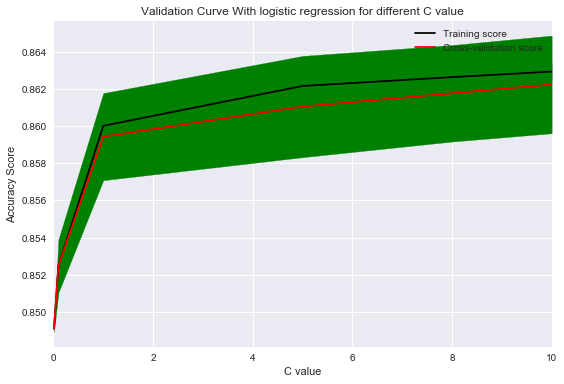

In [34]:
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Conclusion

1. Increasing C
We can see as C decreases i.e. lambda increases more coefficients are getting 0 and test accuracy increases when C too low accuracy decreases again

3. Multicolinearity
After adding some noise on data the weights are almost same so multicolinearity doesnot exist

4. The most important words for positive and negatives are making sense
Accuracy scores are below


In [33]:
aa

,C,penalty,test_score,train_score,type
0,0.001,l2,0.892333,0.974571,Grid search BOW
0,0.010,l2,0.885778,0.990857,Random search BOW
0,0.001,l2,0.830778,0.974571,Grid search TFIDF
0,0.010,l2,0.838333,0.990857,Random search TFIDF
0,10.000,l1,0.829111,0.881714,Grid search AVGW2V
0,100.000,l2,0.829111,0.881714,Random search AVGW2V
0,10.000,l1,0.850444,0.865524,Grid search AVGW2VTFIDF
0,10000.000,l2,0.850333,0.866190,Random search AVGW2VTFIDF


# Steps followed

Only !=3 reviews are taken Mark >3 as positive and <3 as negative. 
Sort data as per product id in ascending order Deduplication of entries for same profilename,userid, time, text 
  and take first element Get stratified sampling of 50k data Clean html and punctuation Convert to uppercase 
and word<3 are rejected data sorted on time Split the data in train and test to 70:30

BOW    
BOW BOW vec created using train data test data is converted using above 
X is standarize on train and same applied to test
y is converted to 1 and 0 from positive and negative
do grid search and random search for different value of c and penalty
best model is established with best hyperparameter. model metric is stored in dataframe and crosstable is printed
print the non zero element of weights
try increasing lambda and see sparsity difference
see top +ve and -ve features using weights sorted in descendng order
Check if multicolinearity exist using pertubation test
plot cv error with C and penalty

TFIDF
form tfidf vec using train same is used in test to convert
rest are same

AVG W2V
gensim is used to convert train and test text to W2V AVG seperately
rest are same

AVG TFIDF
form tfidf vec using train same is used in test to convert
gensim and above tfidf is used to convert train and test text to W2V AVG seperately
